# Classify 250 Bird Species

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.callbacks import TensorBoard
###
from keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
###
from keras.optimizers import SGD, RMSprop, Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization,Dropout
from tensorflow.keras.models import Model, Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

dirs = os.listdir('/content/drive/My Drive/TPCN')
print(dirs)

Mounted at /content/drive
['resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 'dataset.zip', 'datasetttt', 'weights.best.hdf5']


In [3]:
!unzip -q '/content/drive/My Drive/TPCN/dataset.zip'

In [4]:
trainDirectory = os.listdir('dataset/train')
species = trainDirectory
trainLabels = species
print(trainLabels)

['OYSTER CATCHER', 'FLAMINGO', 'HOOPOES', 'IMPERIAL SHAQ', 'GUINEAFOWL', 'SUPERB STARLING', 'PELICAN', 'INDIAN BUSTARD', 'GRAY CATBIRD', 'RED HEADED WOODPECKER', 'GAMBELS QUAIL', 'JAVA SPARROW', 'SORA', 'RAZORBILL', 'WILSONS BIRD OF PARADISE', 'OKINAWA RAIL', 'SAND MARTIN', 'FLAME TANAGER', 'PURPLE MARTIN', 'SRI LANKA BLUE MAGPIE', 'EASTERN TOWEE', 'GRAY PARTRIDGE', 'AFRICAN CROWNED CRANE', 'RUFUOS MOTMOT', 'HOUSE SPARROW', 'CUBAN TODY', 'ANNAS HUMMINGBIRD', 'VENEZUELIAN TROUPIAL', 'NORTHERN MOCKINGBIRD', 'BAR-TAILED GODWIT', 'RED HONEY CREEPER', 'KILLDEAR', 'OSPREY', 'EURASIAN GOLDEN ORIOLE', 'ROSY FACED LOVEBIRD', 'INDIAN PITTA', 'ALEXANDRINE PARAKEET', 'CALIFORNIA CONDOR', 'WOOD DUCK', 'BLACK-NECKED GREBE', 'BARN SWALLOW', 'GREEN JAY', 'PUFFIN', 'CHUKAR PARTRIDGE', 'CROWNED PIGEON', 'CARMINE BEE-EATER', 'BANANAQUIT', 'BOBOLINK', 'BLACK SWAN', 'RAINBOW LORIKEET', 'COMMON STARLING', 'MALLARD DUCK', 'NICOBAR PIGEON', 'MALEO', 'LONG-EARED OWL', 'SNOWY OWL', 'ANTBIRD', 'D-ARNAUDS BARBET'

In [5]:
nSpecies = len(np.unique(species))
print('Number of species for train:', nSpecies)

Number of species for train: 250


In [6]:
testSpecies = os.listdir('dataset/test')
testLabels = testSpecies
print('Number of test species:',len(np.unique(testSpecies)))

valid = os.listdir('dataset/valid')
validationLabels = valid
print('Number of validation species:',len(np.unique(valid)))

Number of test species: 250
Number of validation species: 250


#### Print one of the training images

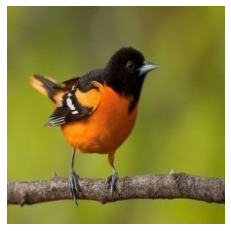

Image size + color channels: (224, 224, 3)


In [7]:
img = load_img('dataset/train/BALTIMORE ORIOLE/027.jpg')
plt.imshow(img)
plt.axis("off")
plt.show()

imgData = img_to_array(img)
shape = imgData.shape
print('Image size + color channels:', shape)

#### Number of images of each species

In [8]:
# train dataset
n = []
for dirr in species: 
    list = os.listdir('dataset/train')
    n.append(len(list))

print('Train - Minimum number of images found in a class:', min(n))
print('Train - Maximum number of images found in a class:', max(n), '\n')

# test dataset
ntest = []
for dirr in species: 
    list = os.listdir('dataset/test')
    ntest.append(len(list))

print('Test - Minimum number of images found in a class:', min(ntest))
print('Test - Maximum number of images found in a class:', max(ntest), '\n')

# validation dataset
nval = []
for dirr in species:
    d = os.path.join('dataset', 'valid')    
    list = os.listdir('dataset/valid')
    nval.append(len(list))

print('Valid - Minimum number of images found in a class:', min(nval))
print('Valid - Maximum number of images found in a class:', max(nval))

Train - Minimum number of images found in a class: 250
Train - Maximum number of images found in a class: 250 

Test - Minimum number of images found in a class: 250
Test - Maximum number of images found in a class: 250 

Valid - Minimum number of images found in a class: 250
Valid - Maximum number of images found in a class: 250


#### Visual analysis of the distribuition of the images on all the datasets

{'boxes': [<matplotlib.lines.Line2D at 0x7f736fbf51d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f736fb81190>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f736fb8a210>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f736fb81c50>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f736fbf56d0>,
  <matplotlib.lines.Line2D at 0x7f736fbf5c10>]}

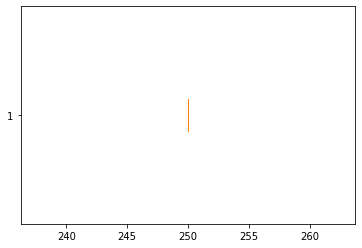

In [9]:
# train dataset
################ax5.set_title('Train Images')
fig5, ax5 = plt.subplots()
square = dict(markerfacecolor='orange')
ax5.boxplot(n, vert=False, flierprops=square)

## Load and prepare images

#### Normalization + No Data Augmentation

In [10]:
datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
# batch_size = 32 (default)
# len(trainData) = number of rows in the train data
trainData = datagen.flow_from_directory('dataset/train', target_size = (224, 224), class_mode='categorical')
steps = len(trainData)
testData = datagen.flow_from_directory('dataset/test', target_size = (224, 224), class_mode='categorical', shuffle = False)
validData = datagen.flow_from_directory('dataset/valid', target_size = (224, 224), class_mode='categorical')
stepsValid = len(validData)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


#### Normalization + Data Augmentation

In [12]:
datagen = ImageDataGenerator(rescale = 1./255, 
                             rotation_range = 0.2,
                             shear_range = 0.5,
                             horizontal_flip=True,
                             vertical_flip=True)

In [13]:
trainDA = datagen.flow_from_directory('dataset/train', target_size = (224,224), class_mode='categorical')
stepsDA = len(trainData)
testDA= datagen.flow_from_directory('dataset/test', target_size = (224,224), class_mode='categorical', shuffle = False)
validDA = datagen.flow_from_directory('dataset/valid', target_size = (224,224), class_mode='categorical')
stepsValidDA = len(validData)

Found 35215 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.
Found 1250 images belonging to 250 classes.


# CNN


In [15]:
def createModel():
    cl = 3
    cFilter = 128
    aFunc = 'relu' 
    drop = 0.25
    
    model = Sequential()
    
    # first convolution layer
    model.add(Conv2D(cFilter, kernel_size=(3,3), padding='same', input_shape=shape, activation='relu'))
    model.add(BatchNormalization())

    # middle convolutional layers  
    for i in range(int(cl)):
        model.add(Conv2D(cFilter, kernel_size=(3,3), padding='same', input_shape=shape, activation=aFunc))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())
        model.add(Dropout(drop))
        
    # flattening
    model.add(Flatten())
    model.add(Dropout(drop))
    # full connection
    model.add(Dense(128,activation=aFunc))
    model.add(BatchNormalization())
    # dropout
    model.add(Dropout(drop))

     # output layer
    model.add(Dense(nSpecies,activation="softmax"))

    #compile model
    model.compile(SGD(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    model.summary()

    return model

In [16]:
model = createModel()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 128)     3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 128)     512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 128)     147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 128)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 128)     512       
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     1

In [16]:
es = EarlyStopping(monitor='val_loss', patience=5)
mc = ModelCheckpoint('bestNOcnn.h5', monitor='val_loss', mode='min', save_best_only=True)

today = datetime.now()
logs = "logs/" + today.strftime('%Y-%m-%d')
tensorboard = TensorBoard(log_dir = logs, histogram_freq = 1, profile_batch = '500,520')

history = model.fit(trainData, steps_per_epoch = steps,
                    epochs=100, verbose=1, 
                    validation_data = validData, validation_steps = stepsValid, 
                    callbacks = [es, mc, tensorboard])

Epoch 1/100
1101/1101 [==============================] - 236s 198ms/step - loss: 5.1967 - accuracy: 0.0519 - precision: 0.3922 - recall: 9.3911e-04 - val_loss: 4.0628 - val_accuracy: 0.1800 - val_precision: 1.0000 - val_recall: 0.0120
Epoch 2/100
1101/1101 [==============================] - 214s 194ms/step - loss: 3.8373 - accuracy: 0.2368 - precision: 0.8499 - recall: 0.0167 - val_loss: 3.3296 - val_accuracy: 0.2984 - val_precision: 0.9839 - val_recall: 0.0488
Epoch 3/100
1101/1101 [==============================] - 214s 194ms/step - loss: 3.0521 - accuracy: 0.3773 - precision: 0.9371 - recall: 0.0688 - val_loss: 2.7067 - val_accuracy: 0.4264 - val_precision: 0.9583 - val_recall: 0.1104
Epoch 4/100
1101/1101 [==============================] - 214s 194ms/step - loss: 2.4432 - accuracy: 0.4917 - precision: 0.9409 - recall: 0.1505 - val_loss: 2.5443 - val_accuracy: 0.4376 - val_precision: 0.9171 - val_recall: 0.1592
Epoch 5/100
1101/1101 [==============================] - 214s 194ms/step

40/40 [==============================] - 3s 68ms/step - loss: 1.4370 - accuracy: 0.6568 - precision: 0.8260 - recall: 0.5848
Test loss: 1.4369747638702393
Test accuracy: 0.6567999720573425
Test Precision: 0.8259887099266052
Test Recall: 0.5848000049591064


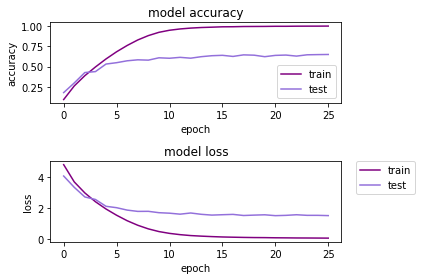

In [17]:
# Plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], color='purple')
plt.plot(history.history['val_accuracy'], color='mediumpurple')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'], color='purple')
plt.plot(history.history['val_loss'], color='mediumpurple')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()


# Evaluate against test data.
testCNN = model.evaluate(testData, verbose=1)
print('Test loss:', testCNN[0])
print('Test accuracy:', testCNN[1])
print('Test Precision:', testCNN[2])
print('Test Recall:', testCNN[3])

In [18]:
predictCNN = model.predict(testData)

print(classification_report(testData.classes, tf.argmax(predictCNN, axis=-1)))

              precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.80      0.80      0.80         5
           2       0.33      0.20      0.25         5
           3       0.67      0.40      0.50         5
           4       0.50      1.00      0.67         5
           5       0.67      0.80      0.73         5
           6       0.62      1.00      0.77         5
           7       1.00      0.80      0.89         5
           8       0.67      0.40      0.50         5
           9       0.40      0.80      0.53         5
          10       0.25      0.20      0.22         5
          11       1.00      0.60      0.75         5
          12       1.00      1.00      1.00         5
          13       0.20      0.20      0.20         5
          14       0.83      1.00      0.91         5
          15       1.00      0.20      0.33         5
          16       0.38      0.60      0.46         5
          17       0.56    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
for i, prediction in enumerate(predictCNN):
    predicted_value = tf.argmax(prediction)
    label = predicted_value.numpy()
    print('Predicted a %d. Real value is %d.' %(predicted_value, testData.classes[i]))

Predicted a 145. Real value is 0.
Predicted a 0. Real value is 0.
Predicted a 152. Real value is 0.
Predicted a 0. Real value is 0.
Predicted a 0. Real value is 0.
Predicted a 1. Real value is 1.
Predicted a 121. Real value is 1.
Predicted a 1. Real value is 1.
Predicted a 1. Real value is 1.
Predicted a 1. Real value is 1.
Predicted a 4. Real value is 2.
Predicted a 82. Real value is 2.
Predicted a 2. Real value is 2.
Predicted a 155. Real value is 2.
Predicted a 4. Real value is 2.
Predicted a 87. Real value is 3.
Predicted a 196. Real value is 3.
Predicted a 3. Real value is 3.
Predicted a 198. Real value is 3.
Predicted a 3. Real value is 3.
Predicted a 4. Real value is 4.
Predicted a 4. Real value is 4.
Predicted a 4. Real value is 4.
Predicted a 4. Real value is 4.
Predicted a 4. Real value is 4.
Predicted a 5. Real value is 5.
Predicted a 5. Real value is 5.
Predicted a 131. Real value is 5.
Predicted a 5. Real value is 5.
Predicted a 5. Real value is 5.
Predicted a 6. Real valu

# CNN + Data Augmentation

In [19]:
modelDA = createModel()
early = EarlyStopping(monitor='val_loss', patience=5)
historyDA = modelDA.fit(trainDA, steps_per_epoch = steps,
                              epochs=100, verbose=1, 
                              validation_data = validDA, validation_steps = stepsValidDA, 
                              callbacks =  early)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 224, 224, 128)     3584      
_________________________________________________________________
batch_normalization_10 (Batc (None, 224, 224, 128)     512       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 224, 224, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 128)     0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 112, 112, 128)     512       
_________________________________________________________________
dropout_10 (Dropout)         (None, 112, 112, 128)     0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 128)    

40/40 [==============================] - 3s 68ms/step - loss: 0.9925 - accuracy: 0.7544 - precision_2: 0.8782 - recall_2: 0.6864
Test loss: 0.9925119876861572
Test accuracy: 0.7544000148773193
Test Precision: 0.8781985640525818
Test Recall: 0.6863999962806702


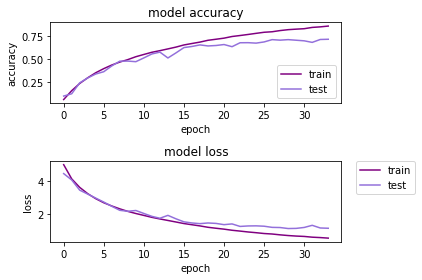

In [20]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(historyDA.history['accuracy'], color='purple')
plt.plot(historyDA.history['val_accuracy'], color='mediumpurple')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(historyDA.history['loss'], color='purple')
plt.plot(historyDA.history['val_loss'], color='mediumpurple')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()

# Evaluate against test data.
testCNN2 = modelDA.evaluate(testData, verbose=1)
print('Test loss:', testCNN2[0])
print('Test accuracy:', testCNN2[1])
print('Test Precision:', testCNN2[2])
print('Test Recall:', testCNN2[3])

In [22]:
testCNN2 = modelDA.predict(testData)

print(classification_report(testData.classes, tf.argmax(testCNN2, axis=-1)))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       1.00      1.00      1.00         5
           2       0.67      0.40      0.50         5
           3       1.00      0.40      0.57         5
           4       0.71      1.00      0.83         5
           5       0.83      1.00      0.91         5
           6       1.00      0.80      0.89         5
           7       0.80      0.80      0.80         5
           8       1.00      0.40      0.57         5
           9       1.00      0.80      0.89         5
          10       0.67      0.80      0.73         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       0.67      0.80      0.73         5
          14       0.83      1.00      0.91         5
          15       1.00      0.80      0.89         5
          16       0.50      0.60      0.55         5
          17       0.71    